In [2]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 15.8 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
import pickle
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import skfuzzy as fuzz
import skfuzzy.control as ctrl

In [10]:
# !pip install streamlit

In [11]:
import numpy as np
import sklearn
import imblearn
import xgboost
import matplotlib
import skfuzzy

print("NumPy:", np.__version__)
print("Scikit-learn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)
print("xgboost:", xgboost.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-fuzzy:", skfuzzy.__version__)

NumPy: 2.0.2
Scikit-learn: 1.6.1
imblearn: 0.13.0
xgboost: 2.1.4
matplotlib: 3.10.0
scikit-fuzzy: 0.5.0


In [12]:
# Load dataset
df = pd.read_csv('/content/diabetes.csv')
print(df.head())
# Handle categorical features
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
df[categorical_cols] = df[categorical_cols].astype(str)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [13]:
# Features and target
x = df.drop(columns=['diabetes'], axis=1)
y = df['diabetes']#save the features
with open('features.pkl','wb') as file:
  pickle.dump(x.columns,file)

#implementing a fuzzy system for handling uncertainty

In [14]:
# Define fuzzy variables
hba1c = ctrl.Antecedent(np.arange(3, 15, 0.1), 'HbA1c_level')
bmi = ctrl.Antecedent(np.arange(10, 50, 0.1), 'bmi')
glucose = ctrl.Antecedent(np.arange(50, 300, 1), 'blood_glucose_level')
risk = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'diabetes_risk')
hypertension_range = np.arange(0, 1.1, 0.1)
hypertension_fuzzy = ctrl.Antecedent(hypertension_range, 'hypertension')
smoking_range = np.arange(0, 1.1, 0.1)
smoking_fuzzy = ctrl.Antecedent(smoking_range, 'smoking')

In [17]:
#Define fuzzy sets (Low, Medium, High)
hba1c.automf(3)
bmi.automf(3)
glucose.automf(3)
risk.automf(3)
#Defining fuzzy set for categorical data
hypertension_fuzzy['absent'] = fuzz.trimf(hypertension_fuzzy.universe, [0, 0, 0.5])
hypertension_fuzzy['present'] = fuzz.trimf(hypertension_fuzzy.universe, [0.5, 1, 1])
smoking_fuzzy['never'] = fuzz.trimf(smoking_fuzzy.universe, [0, 0, 0.3])
smoking_fuzzy['former'] = fuzz.trimf(smoking_fuzzy.universe, [0.2, 0.5, 0.8])
smoking_fuzzy['current'] = fuzz.trimf(smoking_fuzzy.universe, [0.7, 1, 1])

In [18]:
# Example fuzzy rules that incorporate all factors:
rule1 = ctrl.Rule(hba1c['good'] & bmi['good'] & hypertension_fuzzy['present'] & smoking_fuzzy['current'], risk['good'])
rule2 = ctrl.Rule(hba1c['average'] & glucose['average'] & hypertension_fuzzy['absent'] & smoking_fuzzy['former'], risk['average'])
rule3 = ctrl.Rule(hba1c['poor'] & glucose['poor'] & hypertension_fuzzy['absent'] & smoking_fuzzy['never'], risk['poor'])

# Create fuzzy control system
risk_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)
#saving the fuzzy model
with open("fuzzy.pkl", "wb") as file:
    pickle.dump(risk_ctrl, file)


In [19]:
print(x.shape,y.shape)

(100000, 13) (100000,)


In [20]:
#finding missing values
df.isnull().sum()

,0
age,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0
gender_Male,0
gender_Other,0
hypertension_1,0
heart_disease_1,0
smoking_history_current,0


In [21]:
df.value_counts(['diabetes'])

,count
diabetes,
0,91500
1,8500


#our dataset is highly imbalanced so we correct it first

In [22]:
# Apply SMOTE + Tomek Links
smote_tomek = SMOTETomek(sampling_strategy=1.0, random_state=42)
x_resampled, y_resampled = smote_tomek.fit_resample(x, y)

In [23]:
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
 diabetes
0    91243
1    91243
Name: count, dtype: int64


In [24]:
print(x_resampled.shape,y_resampled.shape)

(182486, 13) (182486,)


#standardizing and normalizing data

In [25]:
hba1c_min=x_resampled['HbA1c_level'].min()
hba1c_max=x_resampled['HbA1c_level'].max()
with open('hba1c_min_max.pkl','wb') as file:
  pickle.dump((hba1c_min,hba1c_max),file)

In [26]:
# Normalize HbA1c separately
x_resampled['HbA1c_level'] = (x_resampled['HbA1c_level'] - hba1c_min) / (hba1c_max - hba1c_min)

In [27]:
# Standardizing
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_resampled)
# Saving the scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

#splitting the dataset in test and train data

In [28]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=43)

#hyperparameter tuning

In [29]:
# Hyperparameter tuning for SVM
param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.1, 1, 10]
}

grid = RandomizedSearchCV(
    svm.SVC(kernel='rbf'),
    param_distributions=param_grid,
    n_iter=5,
    cv=2,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

grid.fit(x_train[:20000], y_train[:20000])
best_params = grid.best_params_
print("✅ Best SVM Parameters:", best_params)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ Best SVM Parameters: {'gamma': 'scale', 'C': 1}


#training and testing

In [30]:
# Train SVM model with best params and non linear kernel
classifier = svm.SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])

classifier.fit(x_train, y_train)
# Save the trained model
with open('model.pkl', 'wb') as model_file:
    pickle.dump(classifier, model_file)

normal prediction after hyperparameter tuning

In [31]:
# Model evaluation
y_train_pred = classifier.predict(x_train)
y_test_pred = classifier.predict(x_test)

In [32]:
# Training and Testing Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {100*train_acc:.5f} %")
print(f"Testing Accuracy: {100*test_acc:.5f} %")

Training Accuracy: 93.19533 %
Testing Accuracy: 93.28730 %


In [33]:
# Test predictions before saving
sample_inputs = x_test[:10]
sample_preds = classifier.predict(sample_inputs)

print("Sample Predictions:", sample_preds)
print("Actual Labels:     ", y_test[:10].values)

Sample Predictions: [1 1 1 0 1 0 0 1 0 0]
Actual Labels:      [1 1 1 0 0 1 0 1 0 0]


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test data
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     18249
           1       0.94      0.93      0.93     18249

    accuracy                           0.93     36498
   macro avg       0.93      0.93      0.93     36498
weighted avg       0.93      0.93      0.93     36498

Confusion Matrix:
 [[17097  1152]
 [ 1298 16951]]


#Using gradient boosting


In [35]:
# Train XGBoost model
xgb_classifier = XGBClassifier(n_estimators=600, max_depth=7, learning_rate=0.05,
                               subsample=0.8, colsample_bytree=0.7,
                               gamma=1.15,random_state=9)
xgb_classifier.fit(x_train, y_train)
with open("xgb_model.pkl", "wb") as file:
    pickle.dump(xgb_classifier, file)

In [36]:
# Evaluating XGBoost accuracy
y_train_pred_xgb = xgb_classifier.predict(x_train)
y_test_pred_xgb = xgb_classifier.predict(x_test)

train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"XGBoost Training Accuracy: {100*train_acc_xgb:.5f} %")
print(f"XGBoost Testing Accuracy: {100*test_acc_xgb:.5f} %")

XGBoost Training Accuracy: 97.99641 %
XGBoost Testing Accuracy: 97.63001 %


In [37]:
# Adjusting decision threshold
y_probs = xgb_classifier.predict_proba(x_test)[:, 1]

# Set your decision threshold here (default is 0.5, change as needed)
threshold = 0.25

# Generate predictions based on the new threshold
y_pred_adjusted = (y_probs > threshold).astype(int)

# Evaluate the model using the adjusted predictions
from sklearn.metrics import confusion_matrix, accuracy_score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
print("Adjusted Accuracy:", accuracy_score(y_test, y_pred_adjusted))


Confusion Matrix:
 [[17338   911]
 [  323 17926]]
Adjusted Accuracy: 0.9661899282152446


CHECKING HOW OUR MODEL IS DEPENDENT ON FEATURES THROUGH A VISUAL REPRESENTATION

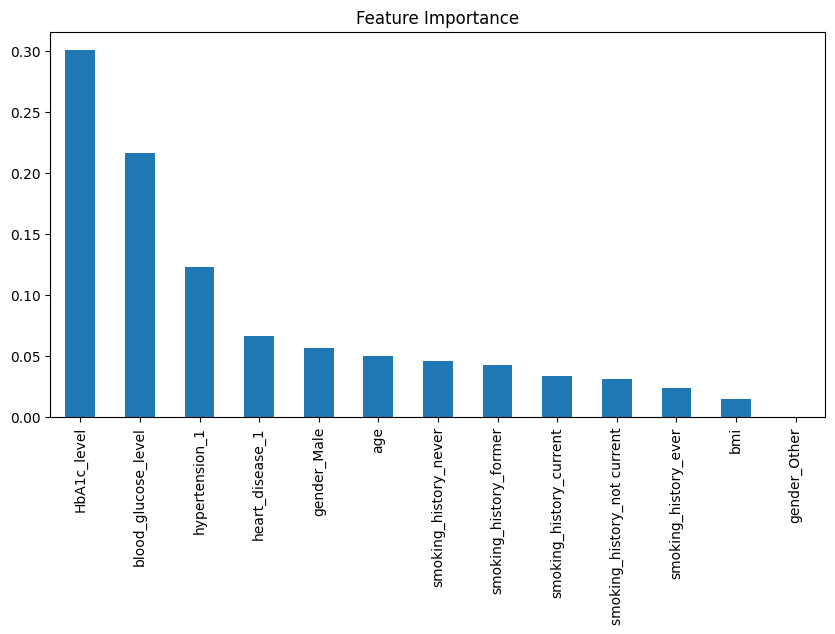

In [38]:
# Check feature importance in XGBoost
feature_importance = pd.Series(xgb_classifier.feature_importances_, index=x.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title="Feature Importance")
plt.show()


CHECKING OUR MODEL

In [39]:
# Test predictions before saving
sample_inputs = x_test[:10]
sample_preds = classifier.predict(sample_inputs)

print("Sample Predictions:", sample_preds)
print("Actual Labels     :", y_test[:10].values)

Sample Predictions: [1 1 1 0 1 0 0 1 0 0]
Actual Labels     : [1 1 1 0 0 1 0 1 0 0]
